# 2 - Métodos de clustering basados en particiones

Vamos a ver algunos ejemplos de clustering con K-means.

En el primer ejemplo, vamos a intentar clusterizar un dataset de números. Este dataset consiste en 1797 imágenes (ejemplos/instancias) con 64 atributos (características/variables/*features*), donde cada una de esos 64 atributos es la intensidad de un pixel de una imagen en escala de grises de 8x8:

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_digits_classification_001.png">

In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
digits = load_digits()
digits.data.shape

(1797, 64)

In [2]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

Fijaos que el resultado del clustering son 10 centroides (1 por cada cluster que le hemos pedido). Además, como hemos utilizado los pixeles "en crudo", estos centroides tienen las mismas dimensiones que las imágenes de entrada (`10x64`) y representan al "típico" número de cada cluster. Vamos a visualizarlos:

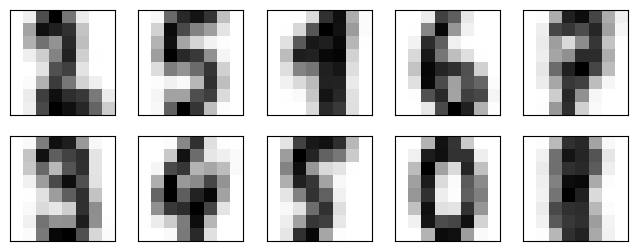

In [3]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Tal y como podemos observar, el K-means es capaz de encontrar los clusters cuyos centros son los números del 0 al 9, a excepción del 1 y el 8 que los confunde un poco.

Vamos a calcular algunas métricas intrínsecas y extrínsecas de las vistas en clase para comprobar cómo ha ido el clustering cuantitativamente.

In [4]:
from sklearn.metrics import cluster
print('Completness score =', cluster.completeness_score(digits.target, clusters))
print('Homogeneidad =', cluster.homogeneity_score(digits.target, clusters))
print('Información mutua (ajustada) =', cluster.adjusted_mutual_info_score(digits.target, clusters))

Completness score = 0.7451645046735983
Homogeneidad = 0.7165701132825527
Información mutua (ajustada) = 0.7278320307690469


¿Y si no supiéramos el número de clusters?

In [5]:
from sklearn import metrics

distortions = []
silhouettes = []

for i in range(2, 20):
    km = KMeans(i, init='random', n_init=10, max_iter=300, tol=1e-4, random_state=42)
    clustering = km.fit_predict(digits.data)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(digits.data, clustering))

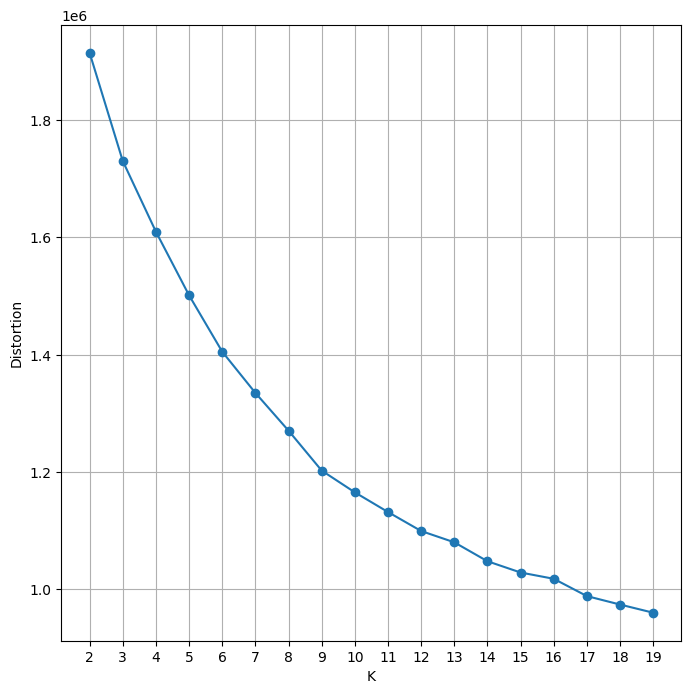

In [6]:
plt.plot(range(2,20), distortions, marker='o')
plt.xticks(range(2, 20))
plt.xlabel('K')
plt.ylabel('Distortion')
plt.grid(True)
plt.show()

In [7]:
# "Satopää et al.: Finding a “Kneedle” in a Haystack: Detecting Knee Points in System Behavior"
!pip install kneed
import kneed

Elbow:  9


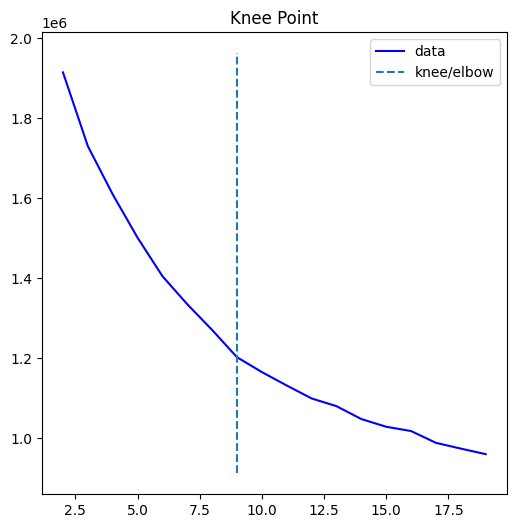

In [8]:
kneedle = kneed.KneeLocator(range(2, 20), distortions[:20], curve="convex", direction="decreasing")
elbow_point = kneedle.elbow
print('Elbow: ', elbow_point)
kneedle.plot_knee()

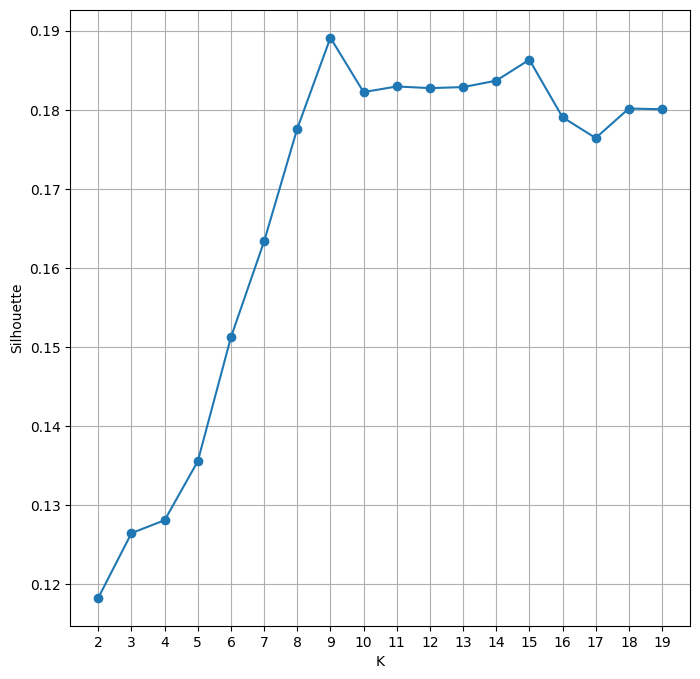

In [9]:
plt.plot(range(2,20), silhouettes , marker='o')
plt.xticks(range(2, 20))
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.grid(True)
plt.show()

Fijaos que, como hemos visto en clase, estas métricas ayudan pero no son infalibles. De hecho, sabemos que tienen que salir 10 clases y, sin embargo, según nuestras métricas sería mejor escoger 9 o 13.

Vamos a ver qué imágenes medias hubiésemos obtenido con 9 y 13 clusters respectivamente, para ayudarnos a entender mejor estos resultados:

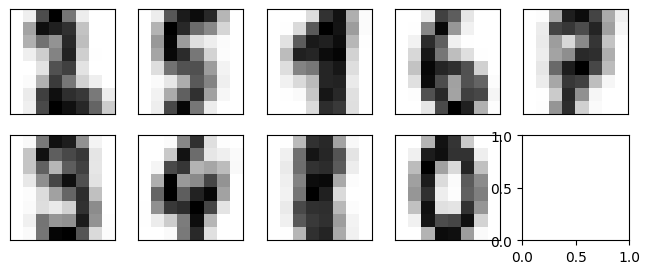

In [10]:
kmeans = KMeans(n_clusters=9, random_state=0)
clusters = kmeans.fit_predict(digits.data)
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(9, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

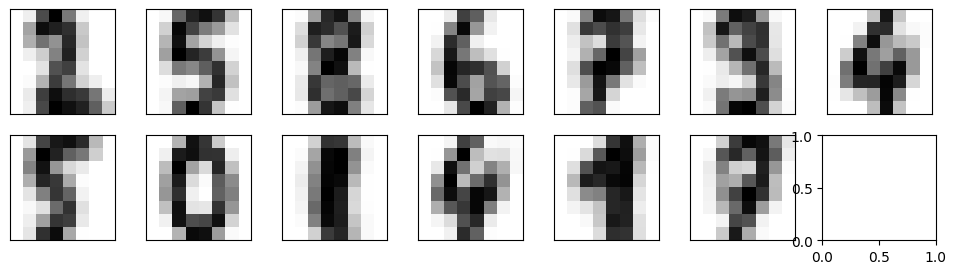

In [11]:
kmeans = KMeans(n_clusters=13, random_state=0)
clusters = kmeans.fit_predict(digits.data)
fig, ax = plt.subplots(2, 7, figsize=(12, 3))
centers = kmeans.cluster_centers_.reshape(13, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Fijaos que pese a que las métricas son mejores, nuestra interpretación nos indica que el mejor clustering es con k=10. De aquí que **siempre** haga falta interpretar los datos, además de considerar las métricas.

### Cálculo del accuracy (porque disponemos de las etiquetas)

OJO: Esta parte pertenecería al aprendizaje supervisado, pero se incluye aquí por completitud.

Ya que tenemos las etiquetas reales, vamos a calcular el accuracy. Para ello, vamos a usar la función `accuracy_score` disponible en  `sklearn.metrics`.

Daos cuenta de que como hemos hablado en las clases, el k-means hace agrupamientos pero no tiene ni idea de a qué *clase* pertenece cada uno. Simplemente agrupa las imágenes por similitud, de forma parecida a lo que haría un *k nearest neighbours (kNN)* o algoritmo de vecinos cercanos.

Por ello, lo primero que vamos a hacer es asignarle a cada cluster la etiqueta de acuerdo a la moda de sus elementos. Es decir, nos fijaremos en qué elemento se repite más en cada cluster, y ese será la etiqueta.

In [12]:
import numpy as np
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Y ahora ya podemos calcular el accuracy:

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.6956037840845855

Y también la matriz de confusión:

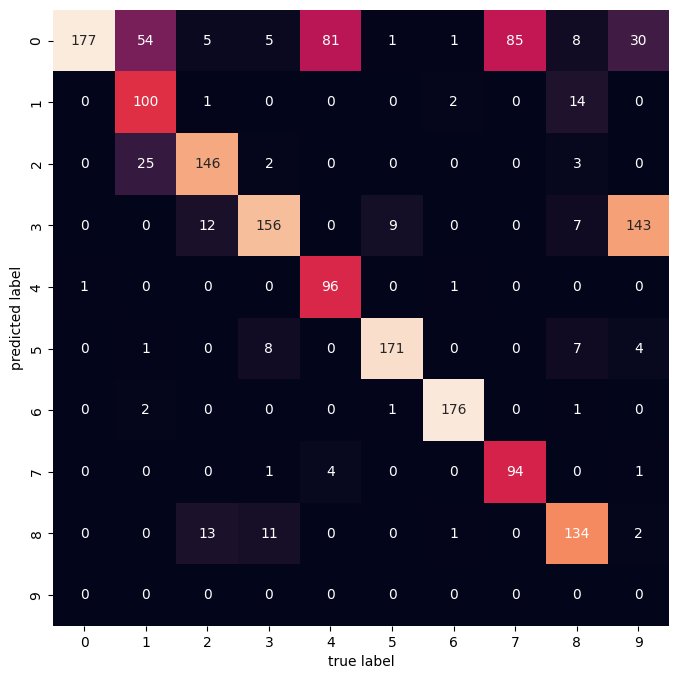

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Fijaos que hemos conseguido clasificar correctamente el 80% de nuestras imágenes con un simple K-means sin siquiera preprocesar los datos. Como hemos comprobado antes al plotear las imágenes, el algoritmo se confunde sobretodo con el 1 y el 8.

¿Y si realizásemos algún tipo de preprocesamiento que nos permitiese mejorar los resultados?

Vamos a ver qué pasaría si usásemos una técnica de reducción de dimensionalidad conocida como t-SNE (https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm):

0.9415692821368948


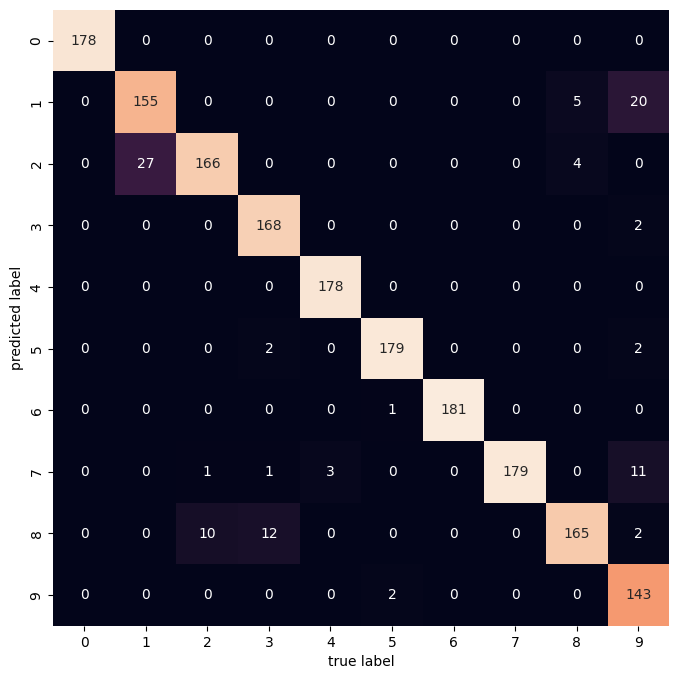

In [15]:
from sklearn.manifold import TSNE

# Utilizamos t-SNE para proyectar los datos en otro espacio de 2 dimensiones
# Este paso tarda unos segundos, no os impacientéis :)
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Realizamos el clustering
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Asignamos las etiquetas de acuerdo a la moda
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Calculamos el accuracy
print(accuracy_score(digits.target, labels))

# Mostramos la matriz de confusión
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

¿Qué os parece? Daos cuenta de la importancia de preprocesar los datos de una forma adecuada. Con esta simple decisión hemos mejorado en un 13% la precisión de nuestro algoritmo.

¡Que no se os olvide! ;)

### Compresión con k-means

El segundo ejemplo que vamos a ver trata sobre compresión de imágenes. Sí, aunque parezca mentira, se pueden usar técnicas de clustering para ello.

Simplemente reducimos el número total de colores utilizados para representar la imagen, y de esta forma permitimos que se necesiten menos memoria (bits) para su almacenaje.

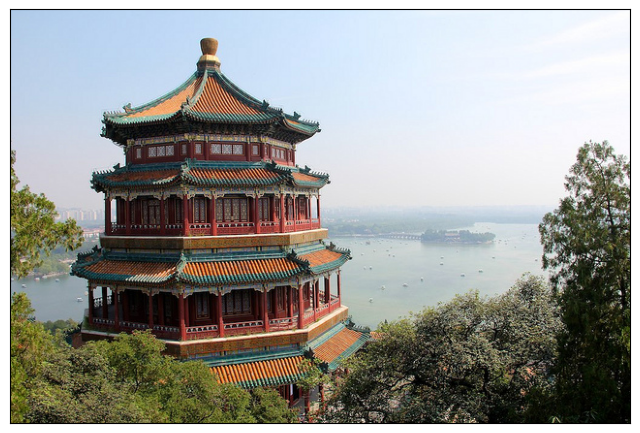

In [16]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

Recordad que las imagenes se representan como matrices de `(alto, ancho, canales)`, donde los valores de los canales son rojo/verde/azul y varían de 0 a 255.

In [17]:
china.shape

(427, 640, 3)

Sin embargo, podemos ver este dataset como una nube de puntos tridimensional, donde cada pixel es una instancia.

Vamos a normalizar los valores entre 0 y 1 y a convertirlos en `[n_instancias, 3]`.

In [18]:
data = china / 255.0
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Ahora vamos a visualizar los pixels:

In [19]:
def plot_pixels(data, title, colors=None, N=10000):
    import numpy as np
    if colors is None:
        colors = data

    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

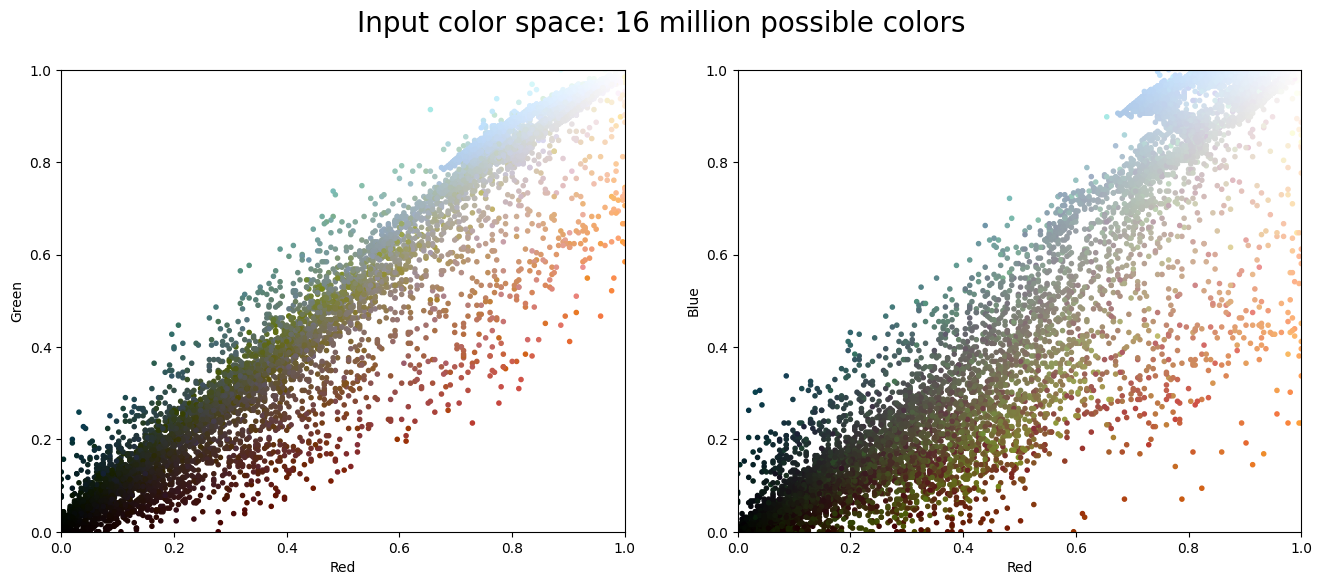

In [20]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Vamos ahora a reducir de 16 millones de colores a 16.

Como se trata de un dataset grande, vamos a usar una variación del k-means llamada mini-batch k-Means, que funciona exactamente igual que el k-means pero con mini-batches.



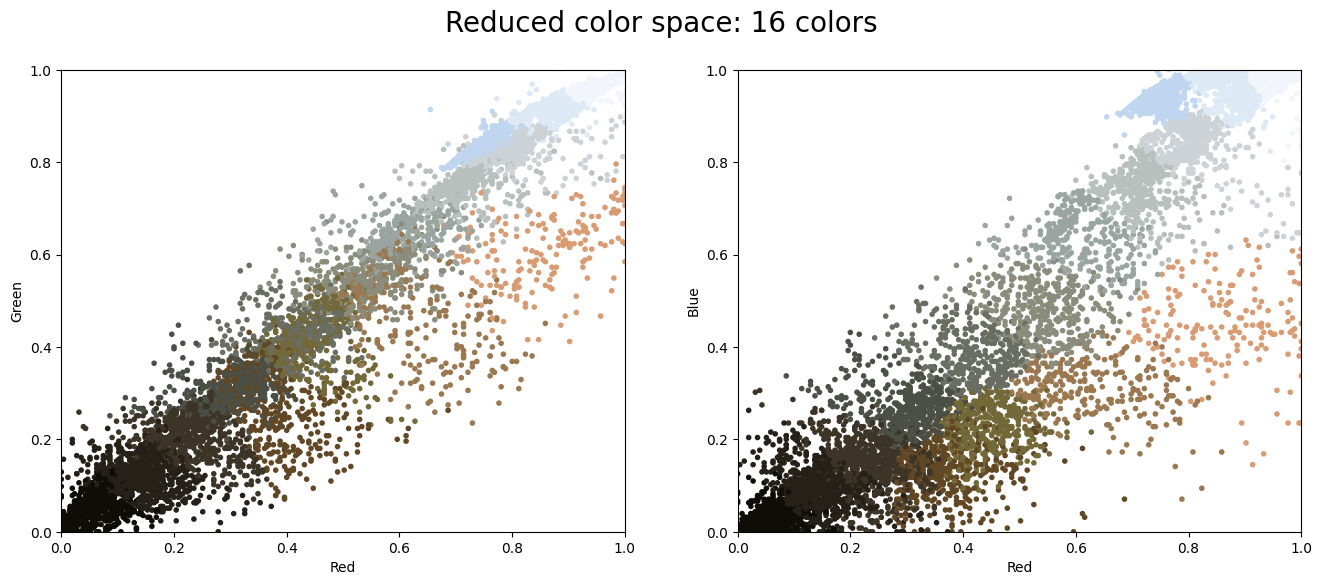

In [21]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")

Perfecto. Acabamos de conseguir reducir el número de colores a 16, como podéis observar.

Vamos a transformar la imagen:

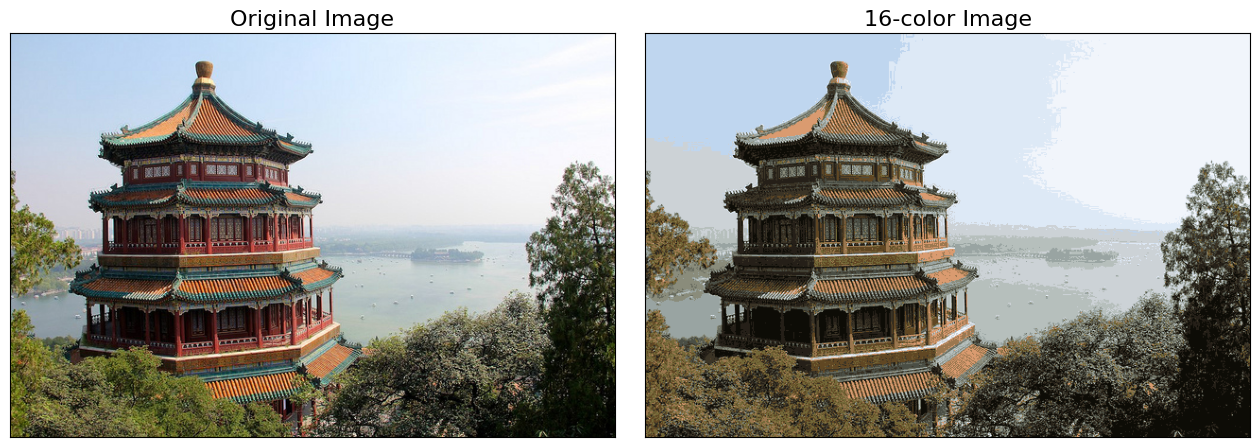

In [22]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Es indiscutible que se pierde calidad, pero pensad que acabamos de conseguir comprimir la imagen a tan solo 16 colores!!!


La fuente de estos ejemplos, para quien quiera consultarla:

*   https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
*   https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html
*   https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
